<a href="https://colab.research.google.com/github/AArchLichKing/CenterNet/blob/Testing-Features/687HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Utils

In [10]:
import pickle
import os
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import approx_fprime
from numpy.linalg import norm

In [11]:
def check_gradient(model, X, y, dimensionality, verbose=True):
    # This checks that the gradient implementation is correct
    w = np.random.rand(dimensionality)
    f, g = model.funObj(w, X, y)

    # Check the gradient
    estimated_gradient = approx_fprime(w,
                                       lambda w: model.funObj(w,X,y)[0],
                                       epsilon=1e-6)

    implemented_gradient = model.funObj(w, X, y)[1]

    if np.max(np.abs(estimated_gradient - implemented_gradient) > 1e-3):
        raise Exception('User and numerical derivatives differ:\n%s\n%s' %
             (estimated_gradient[:5], implemented_gradient[:5]))
    else:
        if verbose:
            print('User and numerical derivatives agree.')

In [12]:
def plotClassifier(model, X, y):
    """plots the decision boundary of the model and the scatterpoints
       of the target values 'y'.

    Assumptions
    -----------
    y : it should contain two classes: '1' and '2'

    Parameters
    ----------
    model : the trained model which has the predict function

    X : the N by D feature array

    y : the N element vector corresponding to the target values

    """
    x1 = X[:, 0]
    x2 = X[:, 1]

    x1_min, x1_max = int(x1.min()) - 1, int(x1.max()) + 1
    x2_min, x2_max = int(x2.min()) - 1, int(x2.max()) + 1

    x1_line =  np.linspace(x1_min, x1_max, 200)
    x2_line =  np.linspace(x2_min, x2_max, 200)

    x1_mesh, x2_mesh = np.meshgrid(x1_line, x2_line)

    mesh_data = np.c_[x1_mesh.ravel(), x2_mesh.ravel()]

    y_pred = model.predict(mesh_data)
    y_pred = np.reshape(y_pred, x1_mesh.shape)

    plt.figure()
    plt.xlim([x1_mesh.min(), x1_mesh.max()])
    plt.ylim([x2_mesh.min(), x2_mesh.max()])

    plt.contourf(x1_mesh, x2_mesh, -y_pred.astype(int), # unsigned int causes problems with negative sign... o_O
                cmap=plt.cm.RdBu, alpha=0.6)


    y_vals = np.unique(y)
    plt.scatter(x1[y==y_vals[0]], x2[y==y_vals[0]], color="b", label="class %+d" % y_vals[0])
    plt.scatter(x1[y==y_vals[1]], x2[y==y_vals[1]], color="r", label="class %+d" % y_vals[1])
    plt.legend()

In [13]:
def findMin(funObj, w, maxEvals, *args, verbose=0):
    """
    Uses gradient descent to optimize the objective function

    This uses quadratic interpolation in its line search to
    determine the step size alpha
    """
    # Parameters of the Optimization
    optTol = 1e-2
    gamma = 1e-4

    # Evaluate the initial function value and gradient
    f, g = funObj(w,*args)
    funEvals = 1

    alpha = 1.
    while True:
        # Line-search using quadratic interpolation to 
        # find an acceptable value of alpha
        gg = g.T.dot(g)

        while True:
            w_new = w - alpha * g
            f_new, g_new = funObj(w_new, *args)

            funEvals += 1
            if f_new <= f - gamma * alpha*gg:
                break

            if verbose > 1:
                print("f_new: %.3f - f: %.3f - Backtracking..." % (f_new, f))

            # Update step size alpha
            alpha = (alpha**2) * gg/(2.*(f_new - f + alpha*gg))

        # Print progress
        if verbose > 0:
            print("%d - loss: %.3f" % (funEvals, f_new))

        # Update step-size for next iteration
        y = g_new - g
        alpha = -alpha*np.dot(y.T,g) / np.dot(y.T,y)

        # Safety guards
        if np.isnan(alpha) or alpha < 1e-10 or alpha > 1e10:
            alpha = 1.

        if verbose > 1:
            print("alpha: %.3f" % (alpha))

        # Update parameters/function/gradient
        w = w_new
        f = f_new
        g = g_new

        # Test termination conditions
        optCond = norm(g, float('inf'))

        if optCond < optTol:
            if verbose:
                print("Problem solved up to optimality tolerance %.3f" % optTol)
            break

        if funEvals >= maxEvals:
            if verbose:
                print("Reached maximum number of function evaluations %d" % maxEvals)
            break

    return w, f

In [14]:
def log_1_plus_exp_safe(x):
    out = np.log(1+np.exp(x))
    out[x > 100] = x[x>100]
    out[x < -100] = np.exp(x[x < -100])
    return out

##Question 4

In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

df = pd.read_csv("/content/nonlineardata.csv", header=None)
X = df.iloc[:,[0,1]].to_numpy()
y = df.iloc[:,[2]].to_numpy().reshape(-1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2022)

###4.1

Training Err: 0.1875	Test Err: 0.2375


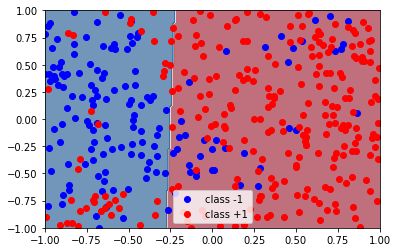

In [22]:
from sklearn.svm import SVC
model = SVC(C=100, kernel='linear')
model.fit(X_train, y_train)
plotClassifier(model, X, y)
print(f"Training Err: {1-model.score(X_train, y_train):.4f}\tTest Err: {1-model.score(X_test, y_test):.4f}")

###4.2

Training Err: 0.1719	Test Err: 0.2250


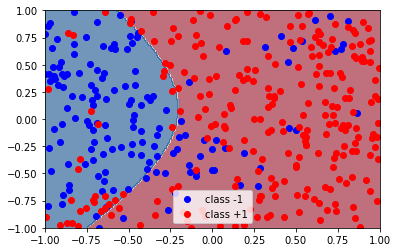

In [35]:
from sklearn.svm import SVC
model = SVC(C=100, kernel='poly', coef0 = 1, degree=2)
model.fit(X_train, y_train)
plotClassifier(model, X, y)
print(f"Training Err: {1-model.score(X_train, y_train):.4f}\tTest Err: {1-model.score(X_test, y_test):.4f}")

###4.3

Training Err: 0.1000	Test Err: 0.1500


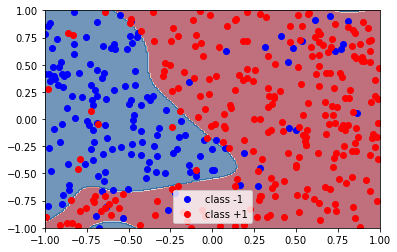

In [37]:
from sklearn.svm import SVC
model = SVC(C=100, kernel='rbf', gamma = 4)
model.fit(X_train, y_train)
plotClassifier(model, X, y)
print(f"Training Err: {1-model.score(X_train, y_train):.4f}\tTest Err: {1-model.score(X_test, y_test):.4f}")

###4.4

The train error rate decreases as $\gamma$ increses, while the test error rates decreases first and then increases. As $\gamma$ increses, the model overfits the training data and hence leading to bad performance on testing data. Small $\gamma$ corresponding to high bias and small variance. 

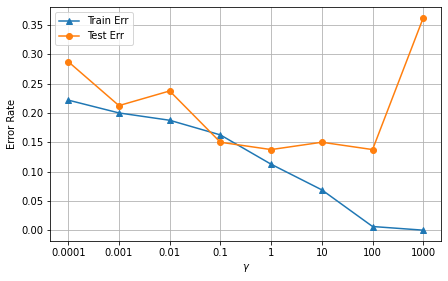

In [54]:
from sklearn.svm import SVC
import matplotlib.pyplot as plt
train_err = []
test_err  = []
for gamma in [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]:
    model = SVC(C=100, kernel='rbf', gamma = gamma)
    model.fit(X_train, y_train)
    train_err.append(1-model.score(X_train, y_train))
    test_err.append(1-model.score(X_test, y_test))
  
fig, ax = plt.subplots(1, figsize=[7,4.3])
x = np.arange(len([0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]))
ax.plot(x, np.asarray(train_err), label=r"Train Err", marker="^")
ax.plot(x, np.asarray(test_err), label=r"Test Err", marker="o")
ax.set_xticklabels([0.0, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000])
ax.set_xlabel(r'$\gamma$')
ax.set_ylabel(r'Error Rate')
ax.legend()
ax.grid(True)
plt.show()

###4.5

In [102]:
import math
import numpy as np

def kernel_linear(X1, X2):
    return X1@X2.T

def kernel_RBF(X1, X2, gamma=4):
    #Your code here
    K = np.zeros([X1.shape[0], X2.shape[0]])
    for i in range(K.shape[0]):
        for j in range(K.shape[1]):
            K[i][j] = np.exp(-gamma*((X1[i]-X2[j]).T@(X1[i]-X2[j])))
    return K

def kernel_poly(X1, X2, p=2):
    #Your code here
    return (1 + X1@X2.T)**2

In [61]:
class kernelLogRegL2():
    def __init__(self, lammy=1.0, verbose=0, maxEvals=100, kernel_fun=kernel_linear, **kernel_args):
        self.verbose = verbose
        self.lammy = lammy
        self.maxEvals = maxEvals
        self.kernel_fun = kernel_fun
        self.kernel_args = kernel_args

    def funObj(self, u, K, y):
        yKu = y * (K@u)

        # Calculate the function value
        # f = np.sum(np.log(1. + np.exp(-yKu)))
        f = np.sum(log_1_plus_exp_safe(-yKu))

        # Add L2 regularization
        f += 0.5 * self.lammy * u.T@K@u

        # Calculate the gradient value
        res = - y / (1. + np.exp(yKu))
        g = (K.T@res) + self.lammy * K@u

        return f, g


    def fit(self, X, y):
        n, d = X.shape
        self.X = X

        K = self.kernel_fun(X,X, **self.kernel_args)

        check_gradient(self, K, y, n, verbose=self.verbose)
        self.u, f = findMin(self.funObj, np.zeros(n), self.maxEvals, K, y, verbose=self.verbose)
    
    def score(self, X, y):
        pred = self.predict(X)
        correct = sum(pred == y)
        return correct / len(y)

    def predict(self, Xtest):
        Ktest = self.kernel_fun(Xtest, self.X, **self.kernel_args)
        return np.sign(Ktest@self.u)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: overflow encountered in exp


Training Err: 0.2375	Test Err: 0.2375


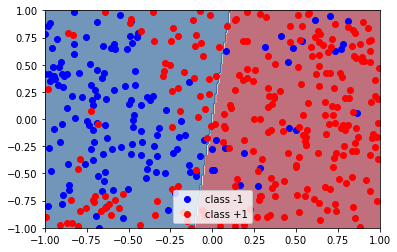

In [59]:
model = kernelLogRegL2(lammy=0.01)
model.fit(X_train, y_train)
plotClassifier(model, X, y)
print(f"Training Err: {1-model.score(X_train, y_train):.4f}\tTest Err: {1-model.score(X_test, y_test):.4f}")

### 4.6

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: overflow encountered in exp


Training Err: 0.1844	Test Err: 0.2375


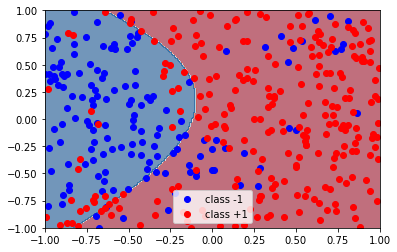

In [62]:
model = kernelLogRegL2(lammy=0.01, kernel_fun=kernel_poly)
model.fit(X_train, y_train)
plotClassifier(model, X, y)
print(f"Training Err: {1-model.score(X_train, y_train):.4f}\tTest Err: {1-model.score(X_test, y_test):.4f}")

###4.7

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: overflow encountered in exp


Training Err: 0.1125	Test Err: 0.1500


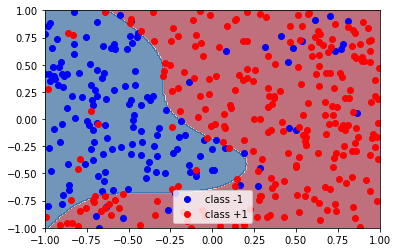

In [103]:
model = kernelLogRegL2(lammy=0.01, kernel_fun=kernel_RBF, gamma=4)
model.fit(X_train, y_train)
plotClassifier(model, X, y)
print(f"Training Err: {1-model.score(X_train, y_train):.4f}\tTest Err: {1-model.score(X_test, y_test):.4f}")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: overflow encountered in exp


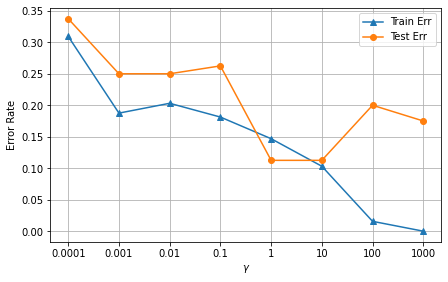

In [104]:
train_err = []
test_err  = []
for gamma in [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]:
    model = kernelLogRegL2(lammy=0.01, kernel_fun=kernel_RBF, gamma=gamma)
    model.fit(X_train, y_train)
    train_err.append(1-model.score(X_train, y_train))
    test_err.append(1-model.score(X_test, y_test))
  
fig, ax = plt.subplots(1, figsize=[7,4.3])
x = np.arange(len([0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]))
ax.plot(x, np.asarray(train_err), label=r"Train Err", marker="^")
ax.plot(x, np.asarray(test_err), label=r"Test Err", marker="o")
ax.set_xticklabels([0.0, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000])
ax.set_xlabel(r'$\gamma$')
ax.set_ylabel(r'Error Rate')
ax.legend()
ax.grid(True)
plt.show()

##Question 5

### 5.1

In [129]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

df = pd.read_csv("/content/spectf.csv", header=None)
X = df.iloc[:,1:].to_numpy()
y = df.iloc[:,0].to_numpy().reshape(-1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2022)

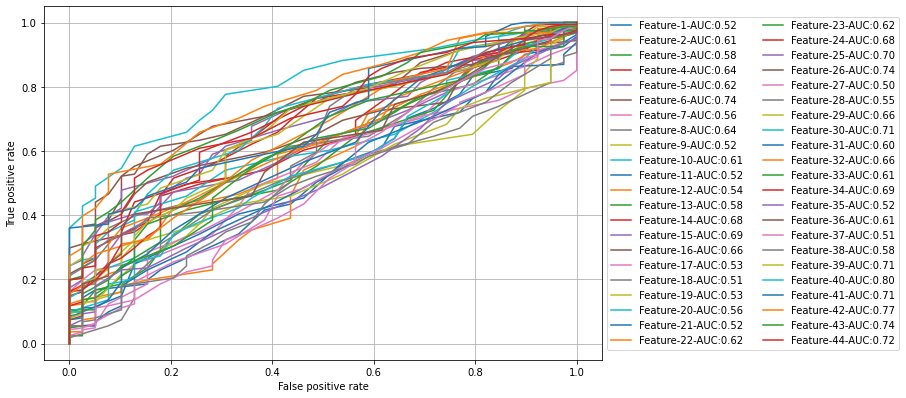

In [133]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
  
fig, ax = plt.subplots(1, figsize=[10,6.5])
auc_list = []
for i in range(X_train.shape[1]):
    auc = roc_auc_score(y_train, X_train[:,i])
    if auc >= 0.5 :
        auc_list.append(auc)
        fpr, tpr, _ = roc_curve(y_train, X_train[:,i])
        ax.plot(fpr, tpr, label=f"Feature-{i+1}-AUC:{roc_auc_score(y_train, X_train[:,i]):.2f}")
    else:
        auc_list.append(1-auc)
        fpr, tpr, _ = roc_curve(y_train, -X_train[:,i])
        ax.plot(fpr, tpr, label=f"Feature-{i+1}-AUC:{roc_auc_score(y_train, -X_train[:,i]):.2f}")

ax.set_xlabel(r'False positive rate')
ax.set_ylabel(r'True positive rate')
ax.legend(ncol=2, loc = "center left", bbox_to_anchor = (1,0.5))
ax.grid(True)
plt.show()

### 5.2

The algorithm contains two steps, the first step is to randomly select several features from features with top-5 AUC. Then for every selected feature, the second step will select a feature that is most uncorrelated with this feature. 

In [221]:
feature_sets = []
df_corr = pd.DataFrame(X_train).corr()
k = 300
for i in range(300):
    #step 1: randomly select a feature from best 15 auc values
    auc_list = np.asarray(auc_list)
    top_auc_list = auc_list.argsort()[-5:][::-1]
    features = list(np.random.choice(top_auc_list, size=1+i//150, replace=False)) #a list containing names

    #step 2: select a feature that is most uncorrelated with selected features 
    #        in step 1
    uncorr_list = []
    for feature in features:
        top_uncorr_list = df_corr[feature].to_numpy().argsort()[:5]
        uncorr_list += list(np.random.choice(top_uncorr_list, size=1+i//150, replace=False))
    features += uncorr_list
    feature_sets.append(features)

### 5.3

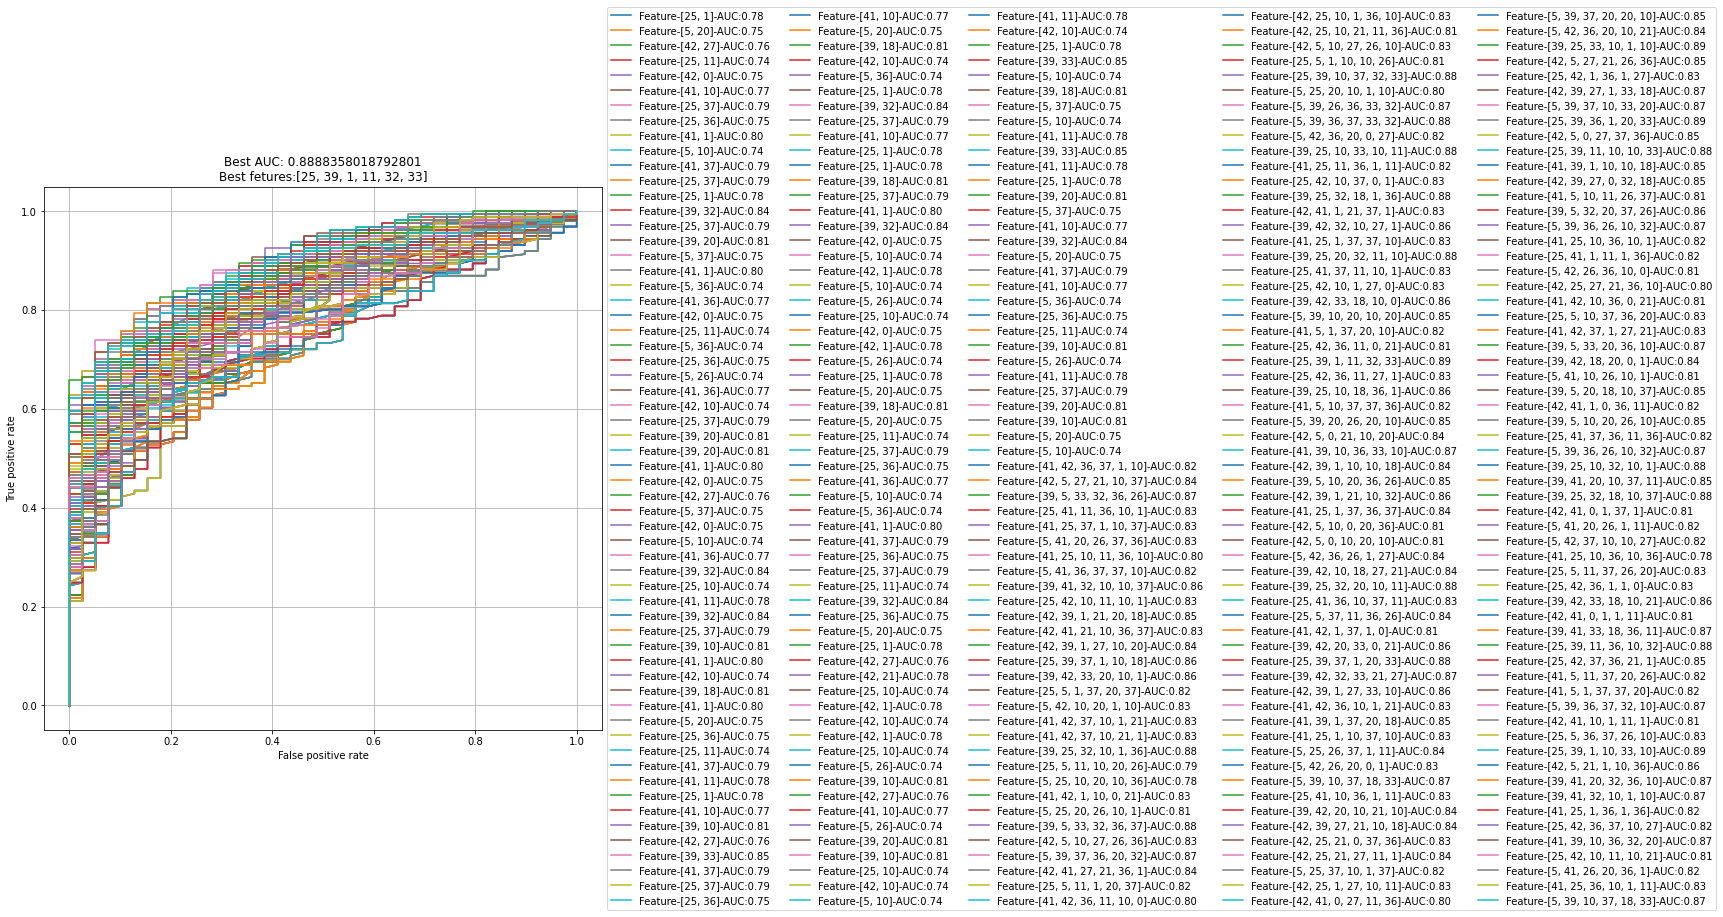

In [226]:
from sklearn.linear_model import LogisticRegression

fig, ax = plt.subplots(1, figsize=[10,10])
best_auc = 0
for features in feature_sets:
    model = LogisticRegression(fit_intercept = True, solver = "lbfgs", max_iter=1000, penalty='none')
    model.fit(X_train[:,features], y_train)
    auc = roc_auc_score(y_train.reshape(-1), model.predict_proba(X_train[:,features])[:,1])
    fpr, tpr, _ = roc_curve(y_train.reshape(-1), model.predict_proba(X_train[:,features])[:,1])
    ax.plot(fpr, tpr, label=f"Feature-{features}-AUC:{auc:.2f}")
    if auc > best_auc:
        best_auc = auc
        best_features = features
        best_model = model

ax.set_xlabel(r'False positive rate')
ax.set_ylabel(r'True positive rate')
ax.set_title(f"Best AUC: {best_auc}\nBest fetures:{best_features}")
ax.legend(ncol=5, loc = "center left", bbox_to_anchor = (1,0.5))
ax.grid(True)
plt.show()

### 5.4

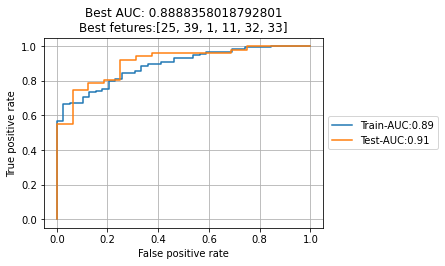

In [223]:
fig, ax = plt.subplots(1, figsize=[5,3.5])
i = 0
names = ["Train", "Test"]
y_plot = [y_train, y_test]
for X_plot in [X_train, X_test]:
    auc = roc_auc_score(y_plot[i], best_model.predict_proba(X_plot[:,best_features])[:,1])
    fpr, tpr, _ = roc_curve(y_plot[i], best_model.predict_proba(X_plot[:,best_features])[:,1])
    ax.plot(fpr, tpr, label=f"{names[i]}-AUC:{auc:.2f}")
    i += 1

ax.set_xlabel(r'False positive rate')
ax.set_ylabel(r'True positive rate')
ax.set_title(f"Best AUC: {best_auc}\nBest fetures:{best_features}")
ax.legend(ncol=1, loc = "center left", bbox_to_anchor = (1,0.5))
ax.grid(True)
plt.show()

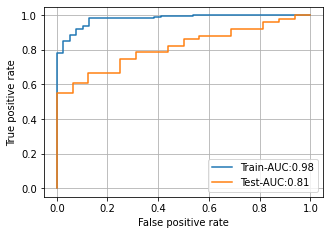

In [225]:
fig, ax = plt.subplots(1, figsize=[5,3.5])
i = 0
names = ["Train", "Test"]
y_plot = [y_train, y_test]
model = LogisticRegression(fit_intercept = True, solver = "lbfgs", max_iter=2000, penalty='l2',  C=5.0)
model.fit(X_train, y_train)
for X_plot in [X_train, X_test]:
    auc = roc_auc_score(y_plot[i], model.predict_proba(X_plot)[:,1])
    fpr, tpr, _ = roc_curve(y_plot[i], model.predict_proba(X_plot)[:,1])
    ax.plot(fpr, tpr, label=f"{names[i]}-AUC:{auc:.2f}")
    i += 1

ax.set_xlabel(r'False positive rate')
ax.set_ylabel(r'True positive rate')
ax.legend()
ax.grid(True)
plt.show()

From the results above, we can see that the sparse logistic regression is actually better than l2-regularized logistic regression in the sense that sparse logistic regression generalize better. 

##Question 6

### 6.1

In [1]:
# Generated dataset
import numpy as np

X = np.random.normal(loc=0.0, size=[100, 5000000])
y = np.random.uniform(low=0.0, high=1.0, size=[100,])

In [2]:
import time

from sklearn.linear_model import Ridge
r_model = Ridge(alpha=1.0, solver='lsqr')
start_time = time.time()
r_model.fit(X, y)
print(f"Time used to train Ridge Regression: {time.time() - start_time}s")

from sklearn.kernel_ridge import KernelRidge
kr_model = Ridge(alpha=1.0)
start_time = time.time()
kr_model.fit(X, y)
print(f"Time used to train Kernel Ridge Regression: {time.time() - start_time}s")

Time used to train Ridge Regression: 2.8621058464050293s
Time used to train Kernel Ridge Regression: 4.022085905075073s


We can see from the above results that Ridge Regression is much faster than the Kernel Ridge Regresion, since in the closed form solution of Kernel Ridge Regression, there is a step to find the inverse of a matrix, which is $O(n^3)$. And the matrix multiplication is around $O(n^{2.37})$. 

###6.2

In [18]:
# Generated dataset
import numpy as np

X = np.random.normal(loc=0.0, size=[1000, 500])
y = np.sin(-np.sum(X,axis=1))

In [19]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

for lambda_ in [0.001, 0.01, 0.1]:
    r_model = Ridge(alpha=lambda_, solver='lsqr')
    l_model = Lasso(alpha=lambda_)

    r_model.fit(X,y)
    l_model.fit(X,y)


    print(f"Coeffcient of Ridge regression with lambda {lambda_}\n{r_model.coef_}")
    print(f"Coeffcient of Lasso regression with lambda {lambda_}\n{l_model.coef_}")
    print("="*80)


Coeffcient of Ridge regression with lambda 0.001
[-0.11178964 -0.01106701 -0.0394355  -0.02464774  0.04124468  0.02151465
  0.00684085  0.04612161  0.01267514 -0.02305233  0.0703394   0.00328436
 -0.00805828  0.01718734  0.02775867  0.00144842  0.0230815  -0.0272447
 -0.02701434  0.01338105  0.00876961 -0.00997066  0.00093623  0.00971466
 -0.03889842  0.02864138  0.01952777  0.02221002  0.00328854  0.00390472
 -0.02114666 -0.00853829  0.02398278  0.00210453  0.01523513 -0.01444369
  0.01370617 -0.0167914  -0.05771886  0.03356732  0.01702006 -0.06965764
 -0.00874296 -0.05181927  0.01276056 -0.01343769  0.00704305 -0.06600217
 -0.01769368  0.05955186 -0.01752405 -0.01164258 -0.0183937  -0.024223
 -0.00595427 -0.01551315  0.01212197  0.01075882  0.00046158 -0.02168933
 -0.02561922 -0.00107299 -0.01159968  0.00067114 -0.00522997 -0.01497267
  0.01984053 -0.02785108  0.06942779  0.01050947 -0.03113659 -0.02046373
  0.06160563  0.04186986 -0.04459262 -0.04346924 -0.00421173  0.0267828
  0.02

Parameters learned have smaller and smaller magnitude as the increase of $\lambda$, while some coefficients in LASSO are zero, implies that LASSO can learn sparse models which performs a feature selection compared with Ridge Regression. 

### 6.3

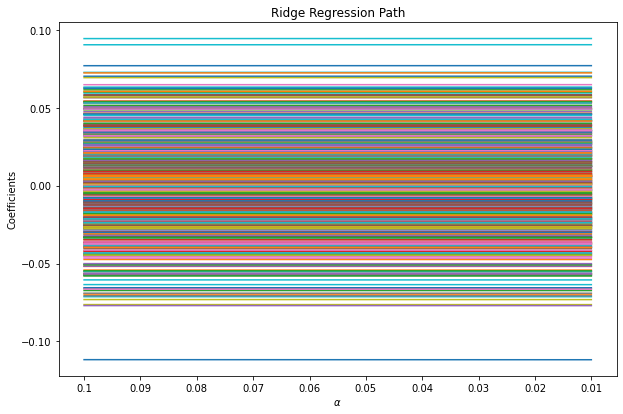

In [40]:
import matplotlib.pyplot as plt

coefs_ = []
for lambda_ in [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]:
    model = Ridge(alpha=lambda_, solver='lsqr')
    model.fit(X, y)
    coefs_.append(model.coef_.ravel().copy())
coefs_ = np.array(coefs_)

fig, ax = plt.subplots(1, figsize=[10,6.5])
ax.plot([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1][::-1], 
        coefs_)
ymin, ymax = plt.ylim()
ax.set_xticks([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1])
ax.set_xticklabels([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1][::-1])
ax.set_xlabel(r"$\alpha$")
ax.set_ylabel("Coefficients")
ax.set_title("Ridge Regression Path")
plt.axis("tight")
plt.show()

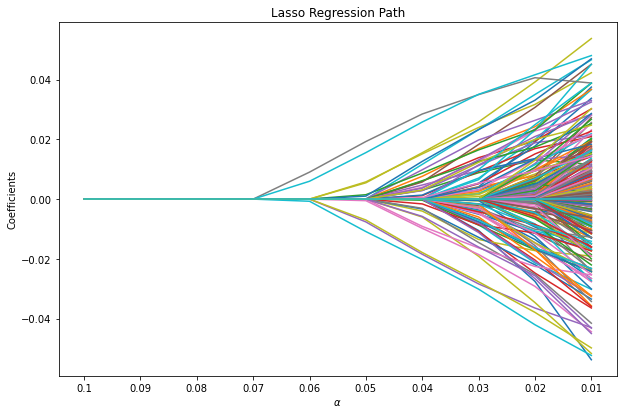

In [39]:
import matplotlib.pyplot as plt

coefs_ = []
for lambda_ in [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]:
    model = Lasso(alpha=lambda_)
    model.fit(X, y)
    coefs_.append(model.coef_.ravel().copy())
coefs_ = np.array(coefs_)

fig, ax = plt.subplots(1, figsize=[10,6.5])
ax.plot([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1][::-1], 
        coefs_)
ymin, ymax = plt.ylim()
ax.set_xticks([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1])
ax.set_xticklabels([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1][::-1])
ax.set_xlabel(r"$\alpha$")
ax.set_ylabel("Coefficients")
ax.set_title("Lasso Regression Path")
plt.axis("tight")
plt.show()